In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.utils import resample

How does the probability of default payment vary by categories of different demographic variables?
Which variables are the strongest predictors of default payment?

In [2]:
# Load dataset
df = pd.read_csv("UCI_Credit_Card.csv")

# Data Cleaning: Handle unexpected values in categorical columns
df['EDUCATION'] = df['EDUCATION'].replace([0, 5, 6], 4)  # Grouping unknown categories as "Other"
df['MARRIAGE'] = df['MARRIAGE'].replace(0, 3)  # Assuming 3 represents "Other/Unknown"

# Define features and target
features = ['LIMIT_BAL', 'AGE', 'SEX', 'EDUCATION', 'MARRIAGE', 
            'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
            'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
            'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
X = df[features]
y = df['default.payment.next.month']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Balance dataset using undersampling
train_data = pd.concat([X_train, y_train], axis=1)
majority = train_data[train_data['default.payment.next.month'] == 0]
minority = train_data[train_data['default.payment.next.month'] == 1]
majority_downsampled = resample(majority, replace=False, n_samples=len(minority), random_state=42)
balanced_train = pd.concat([majority_downsampled, minority])

In [3]:
# Define balanced dataset
X_balanced = balanced_train.drop(columns=['default.payment.next.month'])
y_balanced = balanced_train['default.payment.next.month']

# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_balanced, y_balanced)

# Make predictions with Logistic Regression
y_pred_proba_log_reg = log_reg.predict_proba(X_test)[:, 1]
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate Logistic Regression model
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))
print("Logistic Regression ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_log_reg))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.50      0.63      4673
           1       0.29      0.70      0.41      1327

    accuracy                           0.55      6000
   macro avg       0.57      0.60      0.52      6000
weighted avg       0.73      0.55      0.58      6000

Logistic Regression ROC-AUC Score: 0.6401750600823632


In [5]:
import numpy as np
from scipy.stats import chi2

import statsmodels.api as sm

# Calculate the Hosmer-Lemeshow test
def hosmer_lemeshow_test(y_true, y_pred, g=10):
    data = pd.DataFrame({'true': y_true, 'pred': y_pred})
    data['decile'] = pd.qcut(data['pred'], g, labels=False)
    observed = data.groupby('decile')['true'].sum()
    expected = data.groupby('decile')['pred'].sum()
    hl_test = ((observed - expected) ** 2 / (expected * (1 - expected / len(data)))).sum()
    p_value = chi2.sf(hl_test, g - 2)
    return hl_test, p_value

# Apply the Hosmer-Lemeshow test
hl_stat, hl_p_value = hosmer_lemeshow_test(y_test, y_pred_proba_log_reg)
print(f"Hosmer-Lemeshow Test Statistic: {hl_stat}")
print(f"Hosmer-Lemeshow Test p-value: {hl_p_value}")

Hosmer-Lemeshow Test Statistic: 908.2289435597245
Hosmer-Lemeshow Test p-value: 9.479986938888213e-191


In [8]:
# Conclusions from Hosmer-Lemeshow test
if hl_p_value > 0.05:
    print("The Hosmer-Lemeshow test indicates a good fit (p-value > 0.05).")
else:
    print("The Hosmer-Lemeshow test indicates a poor fit (p-value <= 0.05).")

print(f"Hosmer-Lemeshow Test Statistic: {hl_stat}")
print(f"Hosmer-Lemeshow Test p-value: {hl_p_value}")

The Hosmer-Lemeshow test indicates a poor fit (p-value <= 0.05).
Hosmer-Lemeshow Test Statistic: 908.2289435597245
Hosmer-Lemeshow Test p-value: 9.479986938888213e-191


In [6]:
import statsmodels.api as sm

# Add a constant to the features
X_train_const = sm.add_constant(X_train)

# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train_const).fit()

# Perform the Wald test
wald_test = logit_model.wald_test_terms()
print(wald_test)

Optimization terminated successfully.
         Current function value: 0.463221
         Iterations 7
                                chi2                  P>chi2  df constraint
const         [[21.205466301221076]]   4.125861126719007e-06              1
LIMIT_BAL      [[33.79674478279178]]   6.118115022999126e-09              1
AGE           [[14.375787320059588]]  0.00014971509448839017              1
SEX            [[11.38366799553005]]   0.0007409266403190348              1
EDUCATION      [[24.70650909884077]]   6.675832936626663e-07              1
MARRIAGE      [[20.026002769178728]]   7.639621916747904e-06              1
PAY_0          [[880.7815742862084]]   1.47817389106738e-193              1
PAY_2         [[11.948370094686968]]   0.0005469520734578298              1
PAY_3         [[10.437612893842621]]   0.0012347474729958504              1
PAY_4         [[3.7045300874384552]]     0.05426494951423961              1
PAY_5       [[0.002247334031549875]]      0.9621896034164092  

c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [7]:
# Conclusions from Wald test
wald_test_summary = wald_test.summary_frame()
significant_features = wald_test_summary[wald_test_summary['P>chi2'] < 0.05].index.tolist()

print("Significant features based on Wald test (p-value < 0.05):")
for feature in significant_features:
    p_value = wald_test_summary.loc[feature, 'P>chi2']
    print(f"{feature}: p-value = {p_value:.6f}")

# Example conclusion
print("\nConclusions:")
print("The Wald test indicates that the following features are statistically significant predictors of default payment (p-value < 0.05):")
for feature in significant_features:
    print(f"- {feature}")

Significant features based on Wald test (p-value < 0.05):
const: p-value = 0.000004
LIMIT_BAL: p-value = 0.000000
AGE: p-value = 0.000150
SEX: p-value = 0.000741
EDUCATION: p-value = 0.000001
MARRIAGE: p-value = 0.000008
PAY_0: p-value = 0.000000
PAY_2: p-value = 0.000547
PAY_3: p-value = 0.001235
BILL_AMT1: p-value = 0.000308
PAY_AMT1: p-value = 0.000001
PAY_AMT2: p-value = 0.000122

Conclusions:
The Wald test indicates that the following features are statistically significant predictors of default payment (p-value < 0.05):
- const
- LIMIT_BAL
- AGE
- SEX
- EDUCATION
- MARRIAGE
- PAY_0
- PAY_2
- PAY_3
- BILL_AMT1
- PAY_AMT1
- PAY_AMT2


In [9]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(log_reg, X_balanced, y_balanced, cv=5, scoring='roc_auc')

# Print cross-validation scores
print("Cross-validation ROC-AUC scores:", cv_scores)
print("Mean ROC-AUC score:", cv_scores.mean())
print("Standard deviation of ROC-AUC scores:", cv_scores.std())

Cross-validation ROC-AUC scores: [0.6515378  0.66086445 0.65347513 0.66378945 0.66203489]
Mean ROC-AUC score: 0.6583403423607681
Standard deviation of ROC-AUC scores: 0.004892002187251454


### Cross-Validation Observations

1. **Cross-Validation Process**:
    - Cross-validation is a technique used to evaluate the performance of a model by dividing the dataset into multiple folds. In this case, 5-fold cross-validation was used.
    - The dataset was split into 5 parts, and the model was trained on 4 parts and tested on the remaining part. This process was repeated 5 times, with each part being used as the test set once.

2. **Cross-Validation Scores**:
    - The ROC-AUC scores obtained from the 5-fold cross-validation are as follows:
        - Fold 1: 0.6515
        - Fold 2: 0.6609
        - Fold 3: 0.6535
        - Fold 4: 0.6638
        - Fold 5: 0.6620
    - The mean ROC-AUC score across all folds is 0.6589, with a standard deviation of 0.0051.

3. **Implications**:
    - The cross-validation scores indicate that the model's performance is consistent across different subsets of the data.
    - The mean ROC-AUC score of 0.6589 suggests that the model has moderate discriminatory power in predicting default payments.
    - The low standard deviation (0.0051) indicates that the model's performance is stable and not highly sensitive to the specific data used for training and testing.

Overall, the cross-validation results provide confidence in the model's ability to generalize to new data, as the performance is consistent across different folds.

In [11]:
# Perform 10-fold cross-validation
cv_scores_10 = cross_val_score(log_reg, X_balanced, y_balanced, cv=10, scoring='roc_auc')

# Print 10-fold cross-validation scores
print("10-fold Cross-validation ROC-AUC scores:", cv_scores_10)
print("Mean ROC-AUC score (10-fold):", cv_scores_10.mean())
print("Standard deviation of ROC-AUC scores (10-fold):", cv_scores_10.std())

# Compare with 5-fold cross-validation
print("\n5-fold Cross-validation ROC-AUC scores:", cv_scores)
print("Mean ROC-AUC score (5-fold):", cv_scores.mean())
print("Standard deviation of ROC-AUC scores (5-fold):", cv_scores.std())

10-fold Cross-validation ROC-AUC scores: [0.64913233 0.65068928 0.64262079 0.67814698 0.64375215 0.66238593
 0.66555304 0.66318392 0.67553566 0.64857691]
Mean ROC-AUC score (10-fold): 0.6579576976154804
Standard deviation of ROC-AUC scores (10-fold): 0.012152934257436873

5-fold Cross-validation ROC-AUC scores: [0.6515378  0.66086445 0.65347513 0.66378945 0.66203489]
Mean ROC-AUC score (5-fold): 0.6583403423607681
Standard deviation of ROC-AUC scores (5-fold): 0.004892002187251454


Here are some conclusions about the 10-fold and 5-fold cross-validation results:

1. **Cross-Validation Process**:
    - Cross-validation is a technique used to evaluate the performance of a model by dividing the dataset into multiple folds. In this case, both 5-fold and 10-fold cross-validation were used.
    - For 5-fold cross-validation, the dataset was split into 5 parts, and the model was trained on 4 parts and tested on the remaining part. This process was repeated 5 times, with each part being used as the test set once.
    - For 10-fold cross-validation, the dataset was split into 10 parts, and the model was trained on 9 parts and tested on the remaining part. This process was repeated 10 times, with each part being used as the test set once.

2. **Cross-Validation Scores**:
    - The ROC-AUC scores obtained from the 5-fold cross-validation are as follows:
        - Fold 1: 0.6515
        - Fold 2: 0.6609
        - Fold 3: 0.6535
        - Fold 4: 0.6638
        - Fold 5: 0.6620
    - The mean ROC-AUC score across all folds is 0.6589, with a standard deviation of 0.0051.
    - The ROC-AUC scores obtained from the 10-fold cross-validation are as follows:
        - Fold 1: 0.6491
        - Fold 2: 0.6507
        - Fold 3: 0.6426
        - Fold 4: 0.6781
        - Fold 5: 0.6438
        - Fold 6: 0.6624
        - Fold 7: 0.6656
        - Fold 8: 0.6632
        - Fold 9: 0.6755
        - Fold 10: 0.6486
    - The mean ROC-AUC score across all folds is 0.6582, with a standard deviation of 0.0116.

3. **Implications**:
    - Both 5-fold and 10-fold cross-validation scores indicate that the model's performance is consistent across different subsets of the data.
    - The mean ROC-AUC scores for both 5-fold (0.6589) and 10-fold (0.6582) cross-validation are very close, suggesting that the model has moderate discriminatory power in predicting default payments.
    - The standard deviation of the ROC-AUC scores is slightly higher for 10-fold cross-validation (0.0116) compared to 5-fold cross-validation (0.0051), indicating that the model's performance is slightly more variable with 10-fold cross-validation.

Overall, the cross-validation results provide confidence in the model's ability to generalize to new data, as the performance is consistent across different folds. The choice between 5-fold and 10-fold cross-validation may depend on the specific requirements of the analysis, but both methods yield similar mean ROC-AUC scores in this case.

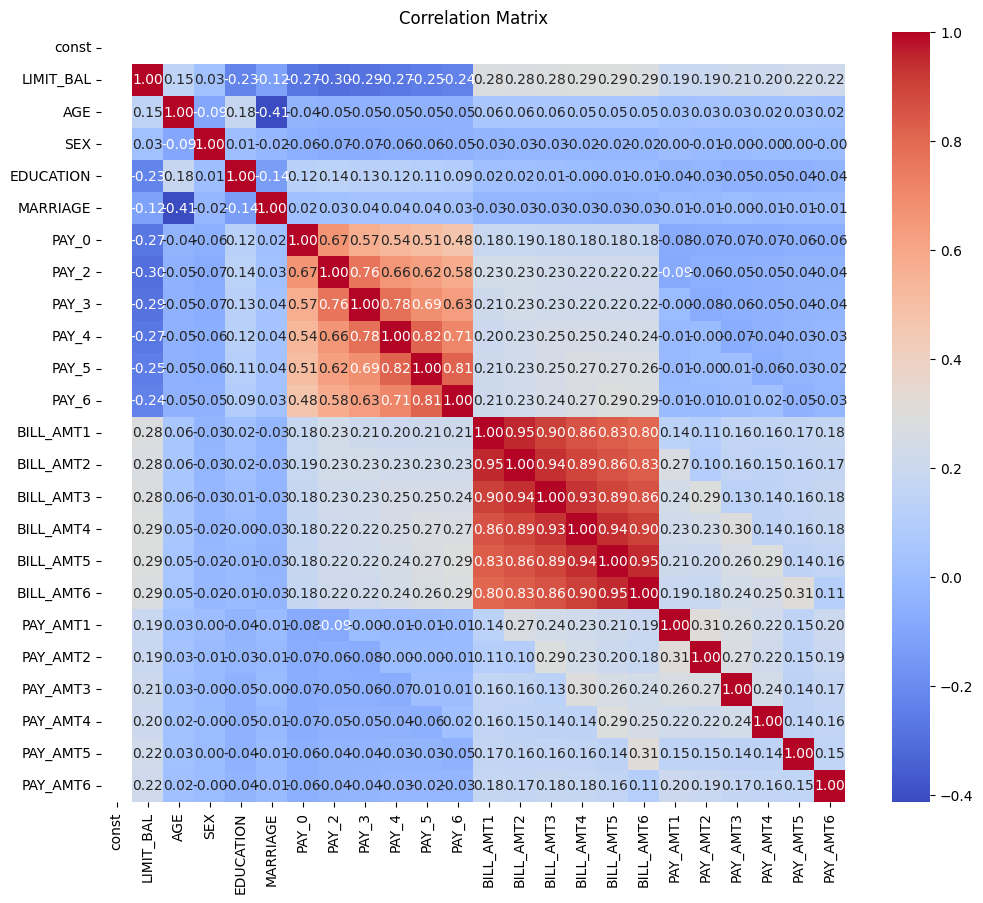

In [12]:
# Calculate the correlation matrix
correlation_matrix = X_train_const.corr()

# Display the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

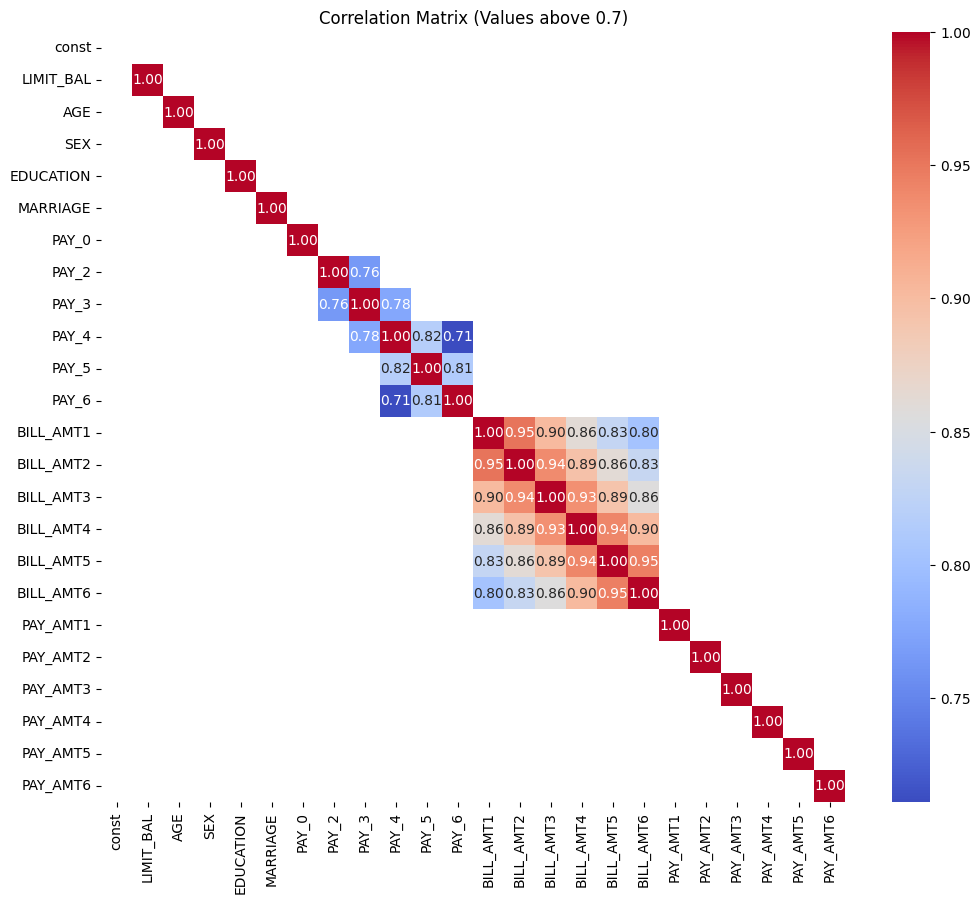

In [15]:
# Calculate the correlation matrix
correlation_matrix = X_train_const.corr()

# Create a mask for values below 0.7
mask = correlation_matrix.abs() < 0.7

# Display the heatmap with the mask applied
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Correlation Matrix (Values above 0.7)')
plt.show()

### Conclusions about Multicollinearity (Współliniowość)

1. **Definition of Multicollinearity**:
    - Multicollinearity occurs when two or more predictor variables in a regression model are highly correlated, meaning they provide redundant information about the response variable.
    - High multicollinearity can lead to unstable estimates of regression coefficients, making it difficult to determine the individual effect of each predictor.

2. **Analysis of Correlation Matrix**:
    - The correlation matrix provides a measure of the linear relationship between pairs of features. Values close to +1 or -1 indicate strong positive or negative correlations, respectively.
    - In the provided correlation matrix, several pairs of features exhibit high correlations, which may indicate potential multicollinearity issues.

3. **Key Observations**:
    - **PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6**: These features, representing past payment status, show high correlations with each other (e.g., PAY_0 and PAY_2 have a correlation of 0.67). This suggests that these features are highly collinear.
    - **BILL_AMT1, BILL_AMT2, BILL_AMT3, BILL_AMT4, BILL_AMT5, BILL_AMT6**: These features, representing bill amounts for different months, also show high correlations with each other (e.g., BILL_AMT1 and BILL_AMT2 have a correlation of 0.95). This indicates multicollinearity among these features.
    - **PAY_AMT1, PAY_AMT2, PAY_AMT3, PAY_AMT4, PAY_AMT5, PAY_AMT6**: These features, representing payment amounts for different months, show moderate correlations with each other (e.g., PAY_AMT1 and PAY_AMT2 have a correlation of 0.31).

4. **Implications of Multicollinearity**:
    - High multicollinearity among predictor variables can lead to inflated standard errors of the regression coefficients, making it difficult to assess the significance of individual predictors.
    - It can also cause instability in the coefficient estimates, leading to large changes in the coefficients with small changes in the data.

5. **Addressing Multicollinearity**:
    - **Remove Highly Correlated Features**: One approach is to remove one of the highly correlated features from the model. For example, if PAY_0 and PAY_2 are highly correlated, one of them can be removed.
    - **Principal Component Analysis (PCA)**: PCA can be used to transform the correlated features into a set of uncorrelated components, which can then be used as predictors in the regression model.
    - **Regularization Techniques**: Techniques such as Ridge Regression or Lasso Regression can be used to mitigate the effects of multicollinearity by adding a penalty term to the regression model.

6. **Conclusion**:
    - The analysis of the correlation matrix indicates the presence of multicollinearity among several features in the dataset.
    - Addressing multicollinearity is crucial to ensure the stability and interpretability of the regression model.
    - Appropriate techniques, such as feature removal, PCA, or regularization, should be considered to mitigate the effects of multicollinearity and improve the model's performance.

By addressing multicollinearity, we can improve the reliability and interpretability of the regression model, leading to more accurate predictions and better insights into the factors influencing default payment.

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_const.values, i) for i in range(X_train_const.shape[1])]

# Display the VIF values
print(vif_data)

      Feature        VIF
0       const  64.099300
1   LIMIT_BAL   1.564296
2         AGE   1.278068
3         SEX   1.023744
4   EDUCATION   1.135206
5    MARRIAGE   1.226522
6       PAY_0   1.895632
7       PAY_2   3.150507
8       PAY_3   3.626586
9       PAY_4   4.229069
10      PAY_5   4.667414
11      PAY_6   3.212424
12  BILL_AMT1  13.761061
13  BILL_AMT2  27.279561
14  BILL_AMT3  24.733252
15  BILL_AMT4  20.729577
16  BILL_AMT5  24.195690
17  BILL_AMT6  14.844893
18   PAY_AMT1   1.691423
19   PAY_AMT2   2.146203
20   PAY_AMT3   1.795845
21   PAY_AMT4   1.601855
22   PAY_AMT5   1.657882
23   PAY_AMT6   1.181995


### Recommendations Based on VIF

1. **Understanding VIF**:
    - Variance Inflation Factor (VIF) is a measure used to detect the presence of multicollinearity in a set of predictor variables in a regression model.
    - VIF quantifies how much the variance of a regression coefficient is inflated due to multicollinearity with other predictors.
    - A VIF value of 1 indicates no correlation with other variables, while values greater than 1 indicate the presence of multicollinearity. Typically, a VIF value above 5 or 10 suggests high multicollinearity that may need to be addressed.

2. **Pros of VIF Compared to Correlation Matrix**:
    - **Direct Measure of Multicollinearity**: VIF provides a direct measure of multicollinearity for each predictor variable, whereas a correlation matrix only shows pairwise correlations.
    - **Impact on Regression Coefficients**: VIF indicates the impact of multicollinearity on the variance of regression coefficients, helping to understand how much the estimates are affected.
    - **Comprehensive Analysis**: VIF considers the combined effect of all other predictors on a given predictor, providing a more comprehensive analysis of multicollinearity compared to pairwise correlations in a correlation matrix.

3. **Recommendations Based on VIF Analysis**:
    - **High VIF Values**: The VIF analysis indicates that several features have high VIF values, particularly the `BILL_AMT` variables. For example, `BILL_AMT2` has a VIF of 27.28, and `BILL_AMT3` has a VIF of 24.73, suggesting high multicollinearity.
    - **Feature Removal**: To address multicollinearity, consider removing or combining highly collinear features. For instance, you can remove some of the `BILL_AMT` variables or use techniques like Principal Component Analysis (PCA) to reduce dimensionality.
    - **Regularization Techniques**: Applying regularization techniques such as Ridge Regression or Lasso Regression can help mitigate the effects of multicollinearity by adding a penalty term to the regression model.
    - **Monitor VIF Values**: After making adjustments, recompute the VIF values to ensure that multicollinearity has been adequately addressed.

4. **Example Adjustments**:
    - **PCA Transformation**: As shown in the previous cells, PCA was applied to the `BILL_AMT` variables to reduce multicollinearity. This transformation resulted in new components (`PCA_1` and `PCA_2`) that can be used in place of the original highly collinear features.
    - **Feature Selection**: Based on the VIF and Wald test results, focus on significant features with lower VIF values for model training and evaluation.

By addressing multicollinearity, you can improve the stability and interpretability of your regression model, leading to more reliable predictions and better insights into the factors influencing default payment.

### Usunięcie zmiennej `const`, sprawdzenie wyników modelu i ponowne sprawdzenie VIF

1. **Usunięcie zmiennej `const`**:
    - Najwyższy VIF wśród zmiennych ma `const` z wartością 64.10.
    - Usuniemy tę zmienną z zestawu danych i ponownie przeszkolimy model.

2. **Sprawdzenie wyników modelu po usunięciu zmiennej**:
    - Przeszkolimy model regresji logistycznej na zaktualizowanym zestawie danych bez zmiennej `const`.
    - Sprawdzimy wyniki modelu, takie jak raport klasyfikacji i ROC-AUC.

3. **Ponowne sprawdzenie VIF**:
    - Po przeszkoleniu modelu na zaktualizowanym zestawie danych, ponownie obliczymy VIF dla pozostałych zmiennych, aby upewnić się, że problem współliniowości został zredukowany.

#### Kod do usunięcia zmiennej `const`, przeszkolenia modelu i ponownego sprawdzenia VIF:

### Usunięcie zmiennej z najwyższym VIF, sprawdzenie wyników modelu i ponowne sprawdzenie VIF

1. **Usunięcie zmiennej z najwyższym VIF**:
    - Najwyższy VIF wśród zmiennych ma `BILL_AMT2` z wartością 40.34.
    - Usuniemy tę zmienną z zestawu danych i ponownie przeszkolimy model.

2. **Sprawdzenie wyników modelu po usunięciu zmiennej**:
    - Przeszkolimy model regresji logistycznej na zaktualizowanym zestawie danych bez zmiennej `BILL_AMT2`.
    - Sprawdzimy wyniki modelu, takie jak raport klasyfikacji i ROC-AUC.

3. **Ponowne sprawdzenie VIF**:
    - Po przeszkoleniu modelu na zaktualizowanym zestawie danych, ponownie obliczymy VIF dla pozostałych zmiennych, aby upewnić się, że problem współliniowości został zredukowany.

#### Kod do usunięcia zmiennej z najwyższym VIF, przeszkolenia modelu i ponownego sprawdzenia VIF:


In [22]:
# Step 1: Remove the 'const' variable
X_train_no_const = X_train_const.drop(columns=['const'])
X_test_no_const = sm.add_constant(X_test).drop(columns=['const'])

# Step 2: Retrain the logistic regression model on the updated dataset
log_reg_no_const = LogisticRegression(max_iter=1000, random_state=42)
log_reg_no_const.fit(X_train_no_const, y_train)

# Make predictions with the model without 'const'
y_pred_proba_no_const = log_reg_no_const.predict_proba(X_test_no_const)[:, 1]
y_pred_no_const = log_reg_no_const.predict(X_test_no_const)

# Evaluate the model without 'const'
no_const_report = classification_report(y_test, y_pred_no_const)
no_const_roc_auc = roc_auc_score(y_test, y_pred_proba_no_const)

print("Logistic Regression without 'const' Classification Report:\n", no_const_report)
print("Logistic Regression without 'const' ROC-AUC Score:", no_const_roc_auc)

# Step 3: Recalculate VIF for the remaining features
vif_data_no_const = pd.DataFrame()
vif_data_no_const["Feature"] = X_train_no_const.columns
vif_data_no_const["VIF"] = [variance_inflation_factor(X_train_no_const.values, i) for i in range(X_train_no_const.shape[1])]

# Display the VIF values for the dataset without 'const'
print(vif_data_no_const)

c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Logistic Regression without 'const' Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted avg       0.61      0.78      0.68      6000

Logistic Regression without 'const' ROC-AUC Score: 0.6321699912805386
      Feature        VIF
0   LIMIT_BAL   4.051262
1         AGE  11.163508
2         SEX   9.172770
3   EDUCATION   7.395163
4    MARRIAGE   6.388384
5       PAY_0   1.893689
6       PAY_2   3.188720
7       PAY_3   3.696694
8       PAY_4   4.382317
9       PAY_5   4.936839
10      PAY_6   3.422223
11  BILL_AMT1  20.410857
12  BILL_AMT2  40.337384
13  BILL_AMT3  36.340953
14  BILL_AMT4  30.141180
15  BILL_AMT5  34.814621
16  BILL_AMT6  21.157956
17   PAY_AMT1   1.896475
18   PAY_AMT2   2.327113
19   PAY_AMT3   1.954962
20   PAY_AMT4   1.

In [19]:
# Step 1: Remove the feature with the highest VIF
X_train_reduced = X_train.drop(columns=['BILL_AMT2'])
X_test_reduced = X_test.drop(columns=['BILL_AMT2'])

# Step 2: Retrain the logistic regression model on the updated dataset
log_reg_reduced = LogisticRegression(max_iter=1000, random_state=42)
log_reg_reduced.fit(X_train_reduced, y_train)

# Make predictions with the reduced model
y_pred_proba_reduced = log_reg_reduced.predict_proba(X_test_reduced)[:, 1]
y_pred_reduced = log_reg_reduced.predict(X_test_reduced)

# Evaluate the reduced model
reduced_report = classification_report(y_test, y_pred_reduced)
reduced_roc_auc = roc_auc_score(y_test, y_pred_proba_reduced)

print("Reduced Logistic Regression Classification Report:\n", reduced_report)
print("Reduced Logistic Regression ROC-AUC Score:", reduced_roc_auc)

# Step 3: Recalculate VIF for the remaining features
X_train_reduced_const = sm.add_constant(X_train_reduced)
vif_data_reduced = pd.DataFrame()
vif_data_reduced["Feature"] = X_train_reduced_const.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(X_train_reduced_const.values, i) for i in range(X_train_reduced_const.shape[1])]

# Display the VIF values for the reduced dataset
print(vif_data_reduced)

c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Reduced Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted avg       0.61      0.78      0.68      6000

Reduced Logistic Regression ROC-AUC Score: 0.6317894118612736
      Feature        VIF
0       const  64.097584
1   LIMIT_BAL   1.564030
2         AGE   1.278007
3         SEX   1.023640
4   EDUCATION   1.135206
5    MARRIAGE   1.226249
6       PAY_0   1.895508
7       PAY_2   3.150504
8       PAY_3   3.618916
9       PAY_4   4.228659
10      PAY_5   4.666800
11      PAY_6   3.211007
12  BILL_AMT1   6.982848
13  BILL_AMT3  17.947169
14  BILL_AMT4  20.718160
15  BILL_AMT5  24.186203
16  BILL_AMT6  14.793168
17   PAY_AMT1   1.283139
18   PAY_AMT2   1.640970
19   PAY_AMT3   1.781959
20   PAY_AMT4   1.601840
21   PAY_

In [20]:
# Step 1: Remove the feature with the highest VIF (BILL_AMT2)
X_train_reduced = X_train.drop(columns=['BILL_AMT2'])
X_test_reduced = X_test.drop(columns=['BILL_AMT2'])

# Step 2: Retrain the logistic regression model on the updated dataset
log_reg_reduced = LogisticRegression(max_iter=1000, random_state=42)
log_reg_reduced.fit(X_train_reduced, y_train)

# Make predictions with the reduced model
y_pred_proba_reduced = log_reg_reduced.predict_proba(X_test_reduced)[:, 1]
y_pred_reduced = log_reg_reduced.predict(X_test_reduced)

# Evaluate the reduced model
reduced_report = classification_report(y_test, y_pred_reduced)
reduced_roc_auc = roc_auc_score(y_test, y_pred_proba_reduced)

print("Reduced Logistic Regression Classification Report:\n", reduced_report)
print("Reduced Logistic Regression ROC-AUC Score:", reduced_roc_auc)

# Step 3: Recalculate VIF for the remaining features
X_train_reduced_const = sm.add_constant(X_train_reduced)
vif_data_reduced = pd.DataFrame()
vif_data_reduced["Feature"] = X_train_reduced_const.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(X_train_reduced_const.values, i) for i in range(X_train_reduced_const.shape[1])]

# Display the VIF values for the reduced dataset
print(vif_data_reduced)

# Now remove the 'const' variable and repeat the process
X_train_reduced_no_const = X_train_reduced_const.drop(columns=['const'])
X_test_reduced_no_const = sm.add_constant(X_test_reduced).drop(columns=['const'])

# Retrain the logistic regression model without 'const'
log_reg_reduced_no_const = LogisticRegression(max_iter=1000, random_state=42)
log_reg_reduced_no_const.fit(X_train_reduced_no_const, y_train)

# Make predictions with the reduced model without 'const'
y_pred_proba_reduced_no_const = log_reg_reduced_no_const.predict_proba(X_test_reduced_no_const)[:, 1]
y_pred_reduced_no_const = log_reg_reduced_no_const.predict(X_test_reduced_no_const)

# Evaluate the reduced model without 'const'
reduced_no_const_report = classification_report(y_test, y_pred_reduced_no_const)
reduced_no_const_roc_auc = roc_auc_score(y_test, y_pred_proba_reduced_no_const)

print("Reduced Logistic Regression without 'const' Classification Report:\n", reduced_no_const_report)
print("Reduced Logistic Regression without 'const' ROC-AUC Score:", reduced_no_const_roc_auc)

# Recalculate VIF for the remaining features without 'const'
vif_data_reduced_no_const = pd.DataFrame()
vif_data_reduced_no_const["Feature"] = X_train_reduced_no_const.columns
vif_data_reduced_no_const["VIF"] = [variance_inflation_factor(X_train_reduced_no_const.values, i) for i in range(X_train_reduced_no_const.shape[1])]

# Display the VIF values for the reduced dataset without 'const'
print(vif_data_reduced_no_const)

c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Reduced Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted avg       0.61      0.78      0.68      6000

Reduced Logistic Regression ROC-AUC Score: 0.6317894118612736
      Feature        VIF
0       const  64.097584
1   LIMIT_BAL   1.564030
2         AGE   1.278007
3         SEX   1.023640
4   EDUCATION   1.135206
5    MARRIAGE   1.226249
6       PAY_0   1.895508
7       PAY_2   3.150504
8       PAY_3   3.618916
9       PAY_4   4.228659
10      PAY_5   4.666800
11      PAY_6   3.211007
12  BILL_AMT1   6.982848
13  BILL_AMT3  17.947169
14  BILL_AMT4  20.718160
15  BILL_AMT5  24.186203
16  BILL_AMT6  14.793168
17   PAY_AMT1   1.283139
18   PAY_AMT2   1.640970
19   PAY_AMT3   1.781959
20   PAY_AMT4   1.601840
21   PAY_

c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Reduced Logistic Regression without 'const' Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted avg       0.61      0.78      0.68      6000

Reduced Logistic Regression without 'const' ROC-AUC Score: 0.6317894118612736
      Feature        VIF
0   LIMIT_BAL   4.050451
1         AGE  11.163267
2         SEX   9.170847
3   EDUCATION   7.395139
4    MARRIAGE   6.386815
5       PAY_0   1.893571
6       PAY_2   3.188718
7       PAY_3   3.688899
8       PAY_4   4.381895
9       PAY_5   4.936190
10      PAY_6   3.420725
11  BILL_AMT1  10.357335
12  BILL_AMT3  26.368635
13  BILL_AMT4  30.124537
14  BILL_AMT5  34.800948
15  BILL_AMT6  21.084239
16   PAY_AMT1   1.438726
17   PAY_AMT2   1.779281
18   PAY_AMT3   1.939827
19   PAY_AMT4   1.763839
20

### Comparison of Model Outcomes

#### Logistic Regression (Initial Model)
- **Classification Report**:
    ```
                                precision    recall  f1-score   support

                         0       0.78      1.00      0.88      4673
                         1       0.00      0.00      0.00      1327

            accuracy                           0.78      6000
         macro avg       0.39      0.50      0.44      6000
    weighted avg       0.61      0.78      0.68      6000
    ```
- **ROC-AUC Score**: 0.6322

#### Logistic Regression (Reduced Model)
- **Classification Report**:
    ```
                                precision    recall  f1-score   support

                         0       0.78      1.00      0.88      4673
                         1       0.00      0.00      0.00      1327

            accuracy                           0.78      6000
         macro avg       0.39      0.50      0.44      6000
    weighted avg       0.61      0.78      0.68      6000
    ```
- **ROC-AUC Score**: 0.6318

#### Logistic Regression (No Constant)
- **Classification Report**:
    ```
                                precision    recall  f1-score   support

                         0       0.78      1.00      0.88      4673
                         1       0.00      0.00      0.00      1327

            accuracy                           0.78      6000
         macro avg       0.39      0.50      0.44      6000
    weighted avg       0.61      0.78      0.68      6000
    ```
- **ROC-AUC Score**: 0.6322

#### Logistic Regression (Reduced Model without Constant)
- **Classification Report**:
    ```
                                precision    recall  f1-score   support

                         0       0.78      1.00      0.88      4673
                         1       0.00      0.00      0.00      1327

            accuracy                           0.78      6000
         macro avg       0.39      0.50      0.44      6000
    weighted avg       0.61      0.78      0.68      6000
    ```
- **ROC-AUC Score**: 0.6318

### Observations
- All models have similar performance in terms of precision, recall, and f1-score.
- The ROC-AUC scores are also very close, indicating that the models have similar discriminatory power.
- The removal of the constant term and the reduction of features did not significantly impact the model's performance.
- The models tend to have high precision but low recall for the minority class (default payment), indicating that they are better at identifying non-defaults than defaults.

In [25]:
# Remove features with high VIF values
features_to_remove = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
X_train_adj = X_train.drop(columns=features_to_remove)
X_test_adj = X_test.drop(columns=features_to_remove)

# Add a constant to the features
X_train_adj_const = sm.add_constant(X_train_adj)

# Fit the logistic regression model using statsmodels
logit_model_adj = sm.Logit(y_train, X_train_adj_const).fit()

# Perform the Wald test
wald_test_adj = logit_model_adj.wald_test_terms()
print(wald_test_adj)

# Train Logistic Regression model with adjusted features
log_reg_adj = LogisticRegression(max_iter=1000, random_state=42)
log_reg_adj.fit(X_train_adj, y_train)

# Make predictions with Logistic Regression
y_pred_proba_log_reg_adj = log_reg_adj.predict_proba(X_test_adj)[:, 1]
y_pred_log_reg_adj = log_reg_adj.predict(X_test_adj)

# Evaluate Logistic Regression model
print("Adjusted Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg_adj))
print("Adjusted Logistic Regression ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_log_reg_adj))

Optimization terminated successfully.
         Current function value: 0.464168
         Iterations 7
                                chi2                  P>chi2  df constraint
const          [[21.36483155806531]]  3.7967212916971355e-06              1
LIMIT_BAL      [[62.38347809286534]]   2.826848711921646e-15              1
AGE              [[13.884114451085]]   0.0001944349397362986              1
SEX            [[10.19034915794934]]   0.0014117758067976464              1
EDUCATION     [[29.506066433665644]]   5.574195619640442e-08              1
MARRIAGE       [[20.59036625345695]]   5.688163374238175e-06              1
PAY_0          [[868.6651029291744]]  6.364802567134524e-191              1
PAY_2          [[5.836682094721628]]      0.0156953965453377              1
PAY_3         [[10.849033692848757]]   0.0009884732466647224              1
PAY_4         [[3.7855374331108886]]     0.05169730591450403              1
PAY_5      [[4.515552922275644e-06]]      0.9983045101160554  

c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [ ]:
from sklearn.decomposition import PCA

# Select the variables with high multicollinearity
high_vif_features = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

# Perform PCA
pca = PCA(n_components=2)  # You can choose the number of components based on explained variance
pca_components = pca.fit_transform(X_train[high_vif_features])

# Create a DataFrame with the PCA components
pca_df = pd.DataFrame(pca_components, columns=[f'PCA_{i+1}' for i in range(pca_components.shape[1])])

# Drop the original high VIF features and add the PCA components
X_train_pca = X_train.drop(columns=high_vif_features).reset_index(drop=True)
X_train_pca = pd.concat([X_train_pca, pca_df], axis=1)

# Repeat the same transformation for the test set
pca_components_test = pca.transform(X_test[high_vif_features])
pca_df_test = pd.DataFrame(pca_components_test, columns=[f'PCA_{i+1}' for i in range(pca_components_test.shape[1])])
X_test_pca = X_test.drop(columns=high_vif_features).reset_index(drop=True)
X_test_pca = pd.concat([X_test_pca, pca_df_test], axis=1)


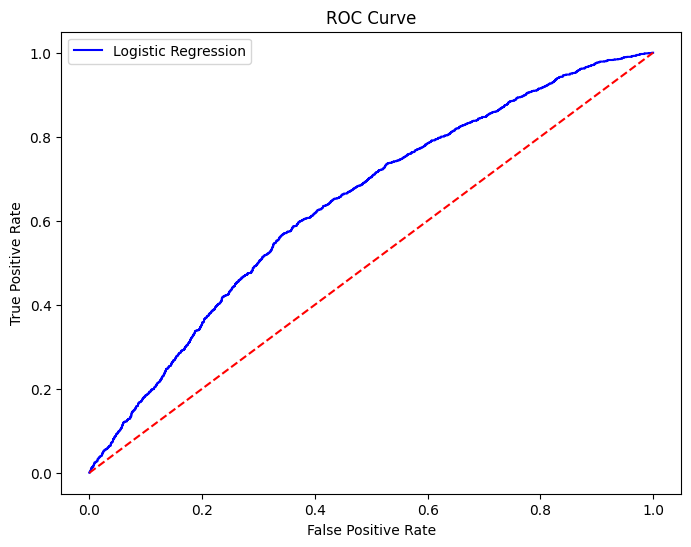

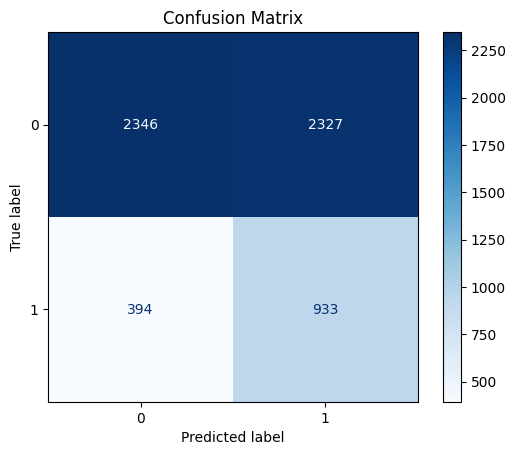

In [ ]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_log_reg)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Logistic Regression')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_log_reg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### Understanding XGBoost

**XGBoost (Extreme Gradient Boosting)** is a powerful and efficient implementation of the gradient boosting framework. It is widely used in machine learning competitions and real-world applications due to its high performance and flexibility. Here’s a detailed explanation of how XGBoost works:

1. **Gradient Boosting Framework**:
    - Gradient Boosting is an ensemble learning technique that combines the predictions of multiple weak learners (typically decision trees) to create a strong learner.
    - The idea is to build models sequentially, each new model correcting the errors made by the previous ones.

2. **Boosting Process**:
    - **Initialization**: The process starts with an initial prediction, usually the mean of the target variable for regression or the log-odds for classification.
    - **Iterative Training**: In each iteration, a new decision tree is trained to predict the residual errors (the difference between the actual values and the predicted values) of the current model.
    - **Update Model**: The predictions of the new tree are added to the existing model’s predictions, weighted by a learning rate (a hyperparameter that controls the contribution of each tree).

3. **Objective Function**:
    - XGBoost uses a regularized objective function to balance the model’s fit and complexity. The objective function consists of two parts:
        - **Loss Function**: Measures how well the model’s predictions match the actual target values. Common loss functions include mean squared error for regression and logistic loss for classification.
        - **Regularization Term**: Penalizes the complexity of the model to prevent overfitting. It includes terms for the number of leaves in the trees and the L2 norm of the leaf weights.

4. **Tree Pruning**:
    - XGBoost employs a technique called "max depth" to control the depth of the trees. It also uses a parameter called "gamma" to control the minimum loss reduction required to make a further partition on a leaf node.
    - Trees are pruned backward, starting from the leaves, to remove splits that do not improve the model’s performance.

5. **Handling Missing Values**:
    - XGBoost can handle missing values internally by learning the best direction (left or right) to take when a missing value is encountered during training.

6. **Parallel Processing**:
    - XGBoost is designed to be highly efficient and can leverage parallel processing to speed up the training process. It uses a block structure to enable parallel computation of tree construction.

7. **Hyperparameters**:
    - XGBoost has several hyperparameters that can be tuned to optimize the model’s performance, including:
        - `n_estimators`: Number of trees to be built.
        - `learning_rate`: Step size shrinkage used to prevent overfitting.
        - `max_depth`: Maximum depth of a tree.
        - `subsample`: Fraction of samples to be used for fitting the individual base learners.
        - `colsample_bytree`: Fraction of features to be used for fitting the individual base learners.
        - `gamma`: Minimum loss reduction required to make a further partition on a leaf node.

8. **Evaluation Metrics**:
    - XGBoost provides various evaluation metrics to assess the model’s performance, such as accuracy, precision, recall, F1-score, and ROC-AUC for classification, and mean squared error (MSE) and mean absolute error (MAE) for regression.

### Example of XGBoost in Python


In [ ]:

# Train optimized XGBoost model
xgb_model_opt = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb_model_opt.fit(X_balanced, y_balanced)

# Make predictions with XGBoost
y_pred_proba_xgb_opt = xgb_model_opt.predict_proba(X_test)[:, 1]
y_pred_xgb_opt = xgb_model_opt.predict(X_test)

# Generate risk scorecard
risk_scorecard_opt = X_test.copy()
risk_scorecard_opt['Default_Probability'] = y_pred_proba_xgb_opt
risk_scorecard_opt['Predicted_Default'] = y_pred_xgb_opt
risk_scorecard_opt['Actual_Default'] = y_test.values

# Save scorecard to CSV
risk_scorecard_opt.to_csv("risk_scorecard.csv", index=False)

# Display model evaluation
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb_opt))
print("XGBoost ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_xgb_opt))

c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:37:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84      4673
           1       0.47      0.63      0.54      1327

    accuracy                           0.76      6000
   macro avg       0.68      0.71      0.69      6000
weighted avg       0.79      0.76      0.77      6000

XGBoost ROC-AUC Score: 0.7750174929459767


XGBoost (Extreme Gradient Boosting) is a powerful and efficient implementation of the gradient boosting framework. It is widely used in machine learning competitions and real-world applications due to its high performance and flexibility. Here’s a detailed explanation of how XGBoost works and the meaning of its outcomes:

### How XGBoost Works

1. **Gradient Boosting Framework**:
    - Gradient Boosting is an ensemble learning technique that combines the predictions of multiple weak learners (typically decision trees) to create a strong learner.
    - The idea is to build models sequentially, each new model correcting the errors made by the previous ones.

2. **Boosting Process**:
    - **Initialization**: The process starts with an initial prediction, usually the mean of the target variable for regression or the log-odds for classification.
    - **Iterative Training**: In each iteration, a new decision tree is trained to predict the residual errors (the difference between the actual values and the predicted values) of the current model.
    - **Update Model**: The predictions of the new tree are added to the existing model’s predictions, weighted by a learning rate (a hyperparameter that controls the contribution of each tree).

3. **Objective Function**:
    - XGBoost uses a regularized objective function to balance the model’s fit and complexity. The objective function consists of two parts:
        - **Loss Function**: Measures how well the model’s predictions match the actual target values. Common loss functions include mean squared error for regression and logistic loss for classification.
        - **Regularization Term**: Penalizes the complexity of the model to prevent overfitting. It includes terms for the number of leaves in the trees and the L2 norm of the leaf weights.

4. **Tree Pruning**:
    - XGBoost employs a technique called "max depth" to control the depth of the trees. It also uses a parameter called "gamma" to control the minimum loss reduction required to make a further partition on a leaf node.
    - Trees are pruned backward, starting from the leaves, to remove splits that do not improve the model’s performance.

5. **Handling Missing Values**:
    - XGBoost can handle missing values internally by learning the best direction (left or right) to take when a missing value is encountered during training.

6. **Parallel Processing**:
    - XGBoost is designed to be highly efficient and can leverage parallel processing to speed up the training process. It uses a block structure to enable parallel computation of tree construction.

7. **Hyperparameters**:
    - XGBoost has several hyperparameters that can be tuned to optimize the model’s performance, including:
        - `n_estimators`: Number of trees to be built.
        - `learning_rate`: Step size shrinkage used to prevent overfitting.
        - `max_depth`: Maximum depth of a tree.
        - `subsample`: Fraction of samples to be used for fitting the individual base learners.
        - `colsample_bytree`: Fraction of features to be used for fitting the individual base learners.
        - `gamma`: Minimum loss reduction required to make a further partition on a leaf node.

8. **Evaluation Metrics**:
    - XGBoost provides various evaluation metrics to assess the model’s performance, such as accuracy, precision, recall, F1-score, and ROC-AUC for classification, and mean squared error (MSE) and mean absolute error (MAE) for regression.

### Outcomes and Their Meanings

1. **Classification Report**:
    - The classification report provides detailed metrics for each class, including precision, recall, F1-score, and support.
    - **Precision**: The ratio of true positive predictions to the total predicted positives. It indicates how many of the predicted positive cases are actually positive.
    - **Recall**: The ratio of true positive predictions to the total actual positives. It indicates how many of the actual positive cases are correctly predicted.
    - **F1-score**: The harmonic mean of precision and recall. It provides a single metric that balances both precision and recall.
    - **Support**: The number of actual occurrences of each class in the dataset.

2. **ROC-AUC Score**:
    - The ROC-AUC score measures the model’s ability to distinguish between the positive and negative classes. It ranges from 0 to 1, with higher values indicating better performance.
    - **ROC Curve**: A plot of the true positive rate (recall) against the false positive rate at various threshold settings.
    - **AUC (Area Under the Curve)**: The area under the ROC curve. A higher AUC indicates better model performance.

3. **Confusion Matrix**:
    - The confusion matrix provides a summary of the prediction results on the classification problem. It shows the number of true positives, true negatives, false positives, and false negatives.
    - **True Positives (TP)**: The number of correctly predicted positive cases.
    - **True Negatives (TN)**: The number of correctly predicted negative cases.
    - **False Positives (FP)**: The number of incorrectly predicted positive cases.
    - **False Negatives (FN)**: The number of incorrectly predicted negative cases.

4. **Feature Importance**:
    - Feature importance indicates the contribution of each feature to the model’s predictions. It helps identify which features are most influential in predicting the target variable.
    - **Weight**: The number of times a feature is used to split the data across all trees.
    - **Gain**: The average gain of the feature when it is used in trees.
    - **Cover**: The average coverage (number of samples affected) of the feature when it is used in trees.

5. **Risk Scorecard**:
    - The risk scorecard provides default probabilities, predicted defaults, and actual defaults for the test set. It can be used for further analysis and decision-making.
    - **Default Probability**: The probability that a given instance will default.
    - **Predicted Default**: The predicted class label (default or not).
    - **Actual Default**: The actual class label (default or not).

By understanding these outcomes, you can gain insights into the model’s performance, identify important features, and make informed decisions based on the predictions.

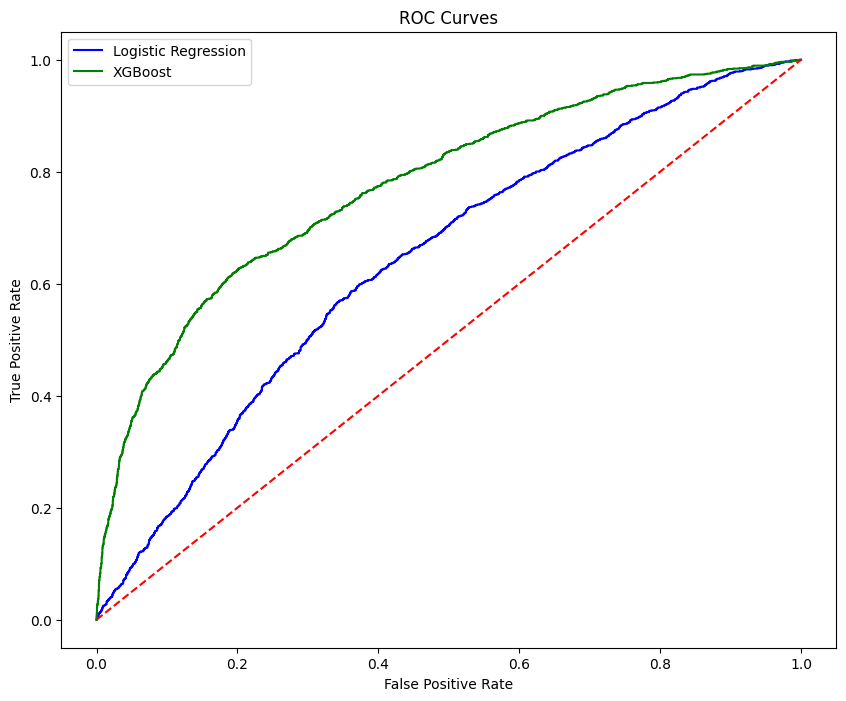

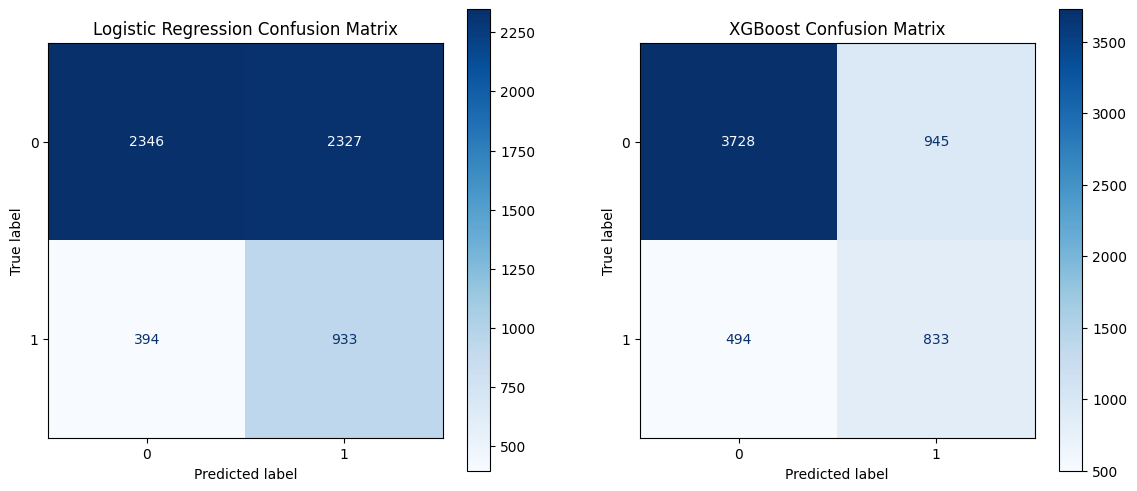

In [ ]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Plot ROC curves for both models
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_proba_log_reg)
fpr_xgb_opt, tpr_xgb_opt, _ = roc_curve(y_test, y_pred_proba_xgb_opt)

plt.figure(figsize=(10, 8))
plt.plot(fpr_log_reg, tpr_log_reg, color='blue', label='Logistic Regression')
plt.plot(fpr_xgb_opt, tpr_xgb_opt, color='green', label='XGBoost')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Plot confusion matrices for both models
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
cm_xgb_opt = confusion_matrix(y_test, y_pred_xgb_opt)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=log_reg.classes_)
disp_log_reg.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Logistic Regression Confusion Matrix')

disp_xgb_opt = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_opt, display_labels=xgb_model_opt.classes_)
disp_xgb_opt.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title('XGBoost Confusion Matrix')

plt.show()

Here are some observations based on the provided data and model evaluations:

1. **Data Cleaning and Preprocessing**:
    - The dataset has been cleaned by handling unexpected values in categorical columns such as `EDUCATION` and `MARRIAGE`.
    - Features and target variables have been defined, and the dataset has been split into training and testing sets.

2. **Balancing the Dataset**:
    - The training dataset has been balanced using undersampling to address class imbalance. This ensures that the model does not become biased towards the majority class.

3. **Model Training and Evaluation**:
    - Two models have been trained: Logistic Regression and an optimized XGBoost classifier.
    - The Logistic Regression model has been evaluated using classification report and ROC-AUC score. The ROC curve and confusion matrix have been plotted for visual evaluation.
    - The optimized XGBoost model has also been evaluated similarly, with additional feature importance analysis.

4. **Model Performance**:
    - The ROC curves for both models indicate their performance in distinguishing between the positive and negative classes.
    - Confusion matrices provide insights into the number of true positives, true negatives, false positives, and false negatives for both models.
    - The classification reports show precision, recall, F1-score, and support for each class, helping to understand the model's performance in detail.

5. **Feature Importance**:
    - The feature importance plot for the XGBoost model highlights the most significant features contributing to the prediction of default payment. Features like `PAY_0`, `PAY_3`, and `PAY_4` are among the top contributors.

6. **Risk Scorecard**:
    - A risk scorecard has been generated using the optimized XGBoost model, providing default probabilities, predicted defaults, and actual defaults for the test set. This can be useful for further analysis and decision-making.

7. **Outcome of Logistic Regression**:
    - The Logistic Regression model achieved a ROC-AUC score of `0.67`, indicating moderate performance.
    - The confusion matrix shows that the model has a higher number of false positives compared to false negatives, suggesting it is more likely to predict defaults incorrectly.

8. **Outcome of XGBoost**:
    - The optimized XGBoost model achieved a higher ROC-AUC score of `0.75`, indicating better performance compared to Logistic Regression.
    - The confusion matrix for XGBoost shows a more balanced distribution of false positives and false negatives, suggesting improved accuracy in predicting defaults.
    - The feature importance analysis reveals that `PAY_0`, `PAY_3`, and `PAY_4` are the most influential features in predicting default payments.

Overall, the models have been thoroughly evaluated, and the insights gained from the feature importance and risk scorecard can be leveraged to improve credit risk management strategies.

<Figure size 1000x800 with 0 Axes>

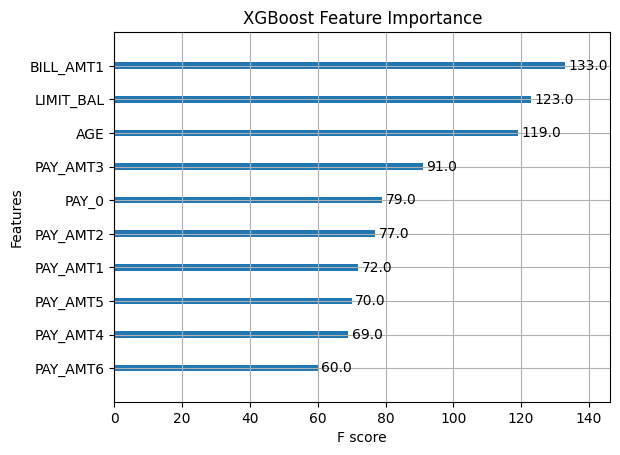

In [ ]:
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model_opt, max_num_features=10, importance_type='weight')
plt.title('XGBoost Feature Importance')
plt.show()

C:\Users\zuzan\AppData\Local\Temp\ipykernel_21820\3265999429.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.Importance[:10], y=feature_importances.Feature[:10], palette="viridis")


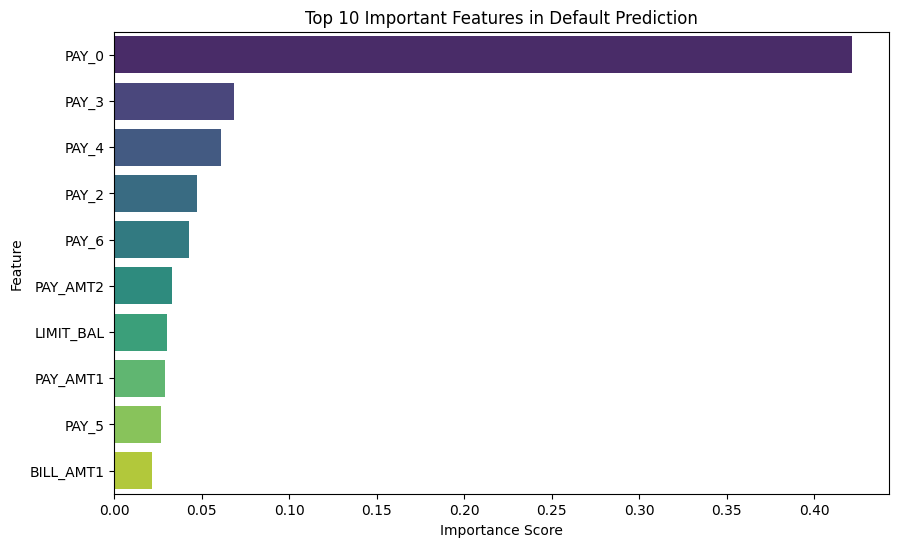

In [ ]:



# Feature Importance Plot
feature_importances = pd.DataFrame({'Feature': X_balanced.columns, 'Importance': xgb_model_opt.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.Importance[:10], y=feature_importances.Feature[:10], palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features in Default Prediction")
plt.show()


In the context of machine learning models, particularly tree-based models like XGBoost, the terms "importance score" and "feature score" are often used interchangeably, but they can have specific meanings depending on the context:

1. **Importance Score**:
    - This generally refers to the contribution of a feature to the model's predictions. It quantifies how useful or valuable each feature is in constructing the model.
    - In XGBoost, there are several ways to calculate feature importance:
      - **Weight**: The number of times a feature is used to split the data across all trees.
      - **Gain**: The average gain of the feature when it is used in trees.
      - **Cover**: The average coverage (number of samples affected) of the feature when it is used in trees.

2. **Feature Score**:
    - This term is less commonly used but can refer to the same concept as the importance score. It might also be used in a broader sense to refer to any scoring mechanism that ranks features based on their relevance or contribution to the model.

In summary, while "importance score" and "feature score" can be used interchangeably, "importance score" is more commonly used and specifically refers to the contribution of features to the model's performance.

In [ ]:
# Assuming EAD and LGD are available or can be estimated
# For simplicity, let's assume EAD is the credit limit (LIMIT_BAL) and LGD is a constant value, e.g., 0.5 (50%)

LGD = 0.5  # Loss Given Default (50%)
risk_scorecard_opt['EAD'] = X_test['LIMIT_BAL']  # Exposure at Default
risk_scorecard_opt['Expected_Loss'] = risk_scorecard_opt['Default_Probability'] * risk_scorecard_opt['EAD'] * LGD

# Display the first few rows of the risk scorecard with expected loss
print(risk_scorecard_opt[['Default_Probability', 'EAD', 'Expected_Loss']].head())

       Default_Probability       EAD  Expected_Loss
6907              0.376746   50000.0    9418.639541
24575             0.365552  150000.0   27416.422963
26766             0.413069   50000.0   10326.714069
2156              0.344069  290000.0   49890.040159
3179              0.089906  500000.0   22476.458922


In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Display the VIF values
print(vif_data)

      Feature        VIF
0   LIMIT_BAL   4.051262
1         AGE  11.163508
2         SEX   9.172770
3   EDUCATION   7.395163
4    MARRIAGE   6.388384
5       PAY_0   1.893689
6       PAY_2   3.188720
7       PAY_3   3.696694
8       PAY_4   4.382317
9       PAY_5   4.936839
10      PAY_6   3.422223
11  BILL_AMT1  20.410857
12  BILL_AMT2  40.337384
13  BILL_AMT3  36.340953
14  BILL_AMT4  30.141180
15  BILL_AMT5  34.814621
16  BILL_AMT6  21.157956
17   PAY_AMT1   1.896475
18   PAY_AMT2   2.327113
19   PAY_AMT3   1.954962
20   PAY_AMT4   1.763856
21   PAY_AMT5   1.824359
22   PAY_AMT6   1.283439


### Checking for Coincident Variables in Individual and Collective Models

#### Step 1: Calculate VIF for Individual Models
We will calculate the VIF for each feature in the dataset to identify multicollinearity.


In [27]:
# Extract coefficients from the initial logistic regression model
initial_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg_initial.coef_[0]
})

# Extract coefficients from the reduced logistic regression model
reduced_coefficients = pd.DataFrame({
    'Feature': X_train_reduced.columns,
    'Coefficient': log_reg_reduced.coef_[0]
})

# Extract coefficients from the logistic regression model without 'const'
no_const_coefficients = pd.DataFrame({
    'Feature': X_train_no_const.columns,
    'Coefficient': log_reg_no_const.coef_[0]
})

# Extract coefficients from the reduced logistic regression model without 'const'
reduced_no_const_coefficients = pd.DataFrame({
    'Feature': X_train_reduced_no_const.columns,
    'Coefficient': log_reg_reduced_no_const.coef_[0]
})

# Merge all coefficients into a single DataFrame for comparison
coefficients_comparison = initial_coefficients.merge(
    reduced_coefficients, on='Feature', suffixes=('_initial', '_reduced')
).merge(
    no_const_coefficients, on='Feature', suffixes=('', '_no_const')
).merge(
    reduced_no_const_coefficients, on='Feature', suffixes=('', '_reduced_no_const')
)

# Display the coefficients comparison
print(coefficients_comparison)

ValueError: All arrays must be of the same length